In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-np.clip(z, -250, 250)))

def deriv_sigmoid(z):  
    return sigmoid(z) * (1 - sigmoid(z))

def tanh(z):
    return np.tanh(np.clip(z, -250, 250))

def deriv_tanh(z):
    return 1 - tanh(z) ** 2

def relu(z, epsilon=1e-5):
    return np.where(z >= 0, z, 0 + epsilon)

def deriv_relu(z, epsilon=1e-5):
    return np.where(z >= 0, 1, 0 + epsilon)

def learning_schedule(n, t0=5, t1=15):
    return t0 / (n + t1)

def encode(y):
    y_enc = np.zeros((len(y), len(np.unique(y))), dtype=int)
    for i, val in enumerate(y):
        y_enc[i, val] = 1
    return y_enc

def logistic_cost(y, y_pred):
    J = - (y * np.log(y_pred) + (1.0 - y) * np.log(1.0 - y_pred))
    return J

def mse(y, y_pred):
    MSE = (y - y_pred) ** 2
    return MSE

In [3]:
class NNOneHiddenLayer:
    
    activation_functions = {'sigmoid': sigmoid, 'tanh': tanh, 'relu': relu}
    deriv_activation_functions = {'sigmoid': deriv_sigmoid, 'tanh': deriv_tanh, 'relu': deriv_relu}
    cost_functions = {'Logistic': logistic_cost, 'MSE': mse}
    
    last_layer_activation = sigmoid
    last_layer_deriv_activation = deriv_sigmoid
        
    
    def __init__(self, hidden_units, activation, cost_function, learning_schedule, eta=0.01, 
                 n_iter=100, random_state=1, ratio_cost=10):
        
        assert activation in self.activation_functions, f'{activation} not in {self.activation_functions}' 
        assert cost_function in self.cost_functions, f'{cost_function} not in {self.cost_functions}'
        assert str(type(learning_schedule)) == "<class 'function'>", ('The type of the learning schedule' + 
                                                                      'must be function')
        
        self.activation = activation
        self.output_activation = self.activation_functions['sigmoid']
        self.deriv_output_activation = self.deriv_activation_functions['sigmoid']
        
        self.activation_function = self.activation_functions[activation]
        self.deriv_activation = self.deriv_activation_functions[activation]
        self.cost_function = self.cost_functions[cost_function]
        
        self.n_h = hidden_units
        
        self.random_state = random_state
        self.eta = eta
        self.n_iter = n_iter
        self.ratio_cost = ratio_cost
        
        self.learning_schedule = learning_schedule
        self.fitted = False
        
    def fit(self, X, y, batch_size=None):
        
        shuffle = True
        if y.ndim == 1:
            y = y.reshape(-1, 1)
            
        if batch_size is None: 
            batch_size = X.shape[1]
            shuffle = False
            
        assert batch_size <= X.shape[1], 'batch_size must be less or equal to n_samples'
        
        self.batch_size = batch_size
        self.n_inp = X.shape[0]
        self.n_out = len(np.unique(y))
        
        self.__random_initialization()
        
        yield_batches = self.__yield_mini_batches(X, y, shuffle)
        self.costs_ = []
        
        for n in range(self.n_iter):
            
            x_batch, y_batch = next(yield_batches)
            Z_h, A_h, Z_out, A_out = self.__forward(x_batch)
                
            parameters = [Z_h, A_h, Z_out, A_out]            
            dw_h, db_h, dw_out, db_out = self.__backward(x_batch, y_batch, parameters)
            
            self.W1_ -= self.eta * dw_h
            self.W2_ -= self.eta * dw_out
            
            self.b1_ -= self.eta * db_h
            self.b2_ -= self.eta * db_out
            
            cost = self._compute_cost(y_batch, A_out)
            self.eta = self.learning_schedule(n)
            
            if not n % self.ratio_cost:
                self.costs_.append(cost)
            
        self.fitted = True
        return self
        
    def predict(self, X):
        A_out = self.__forward(X)[-1]
        y_pred = np.where(A_out >= 0.5, 1, 0)
        return np.argmax(y_pred, axis=0)
        
    def __forward(self, x):
        Z_h = self.W1_.dot(x) + self.b1_
        A_h = self.activation_function(Z_h)
        
        Z_out = self.W2_.dot(A_h) + self.b2_
        A_out = self.output_activation(Z_out) # shape: (n_out, n_samples)
        
        return Z_h, A_h, Z_out, A_out
    
    def __backward(self, X, y, parameters):
        Z_h, A_h, Z_out, A_out = parameters
        
        # first thing we need: activation function derivative
        d_phi_h = self.deriv_activation(A_h)
        d_phi_L = self.deriv_output_activation(A_out)
        
        # now we need the error of the last layer
        delta_L = (A_out - y) * d_phi_L
        
        # the error of the hidden layer
        delta_h = self.W2_.T.dot(delta_L) * d_phi_h
        
        # finally we can compute the gradients of the weights
        grad_w_h = delta_h.dot(X.T)
        grad_b_h = np.sum(delta_h, axis=1).reshape(-1, 1) # that way we get a (n_samples, 1) vector.
        grad_w_out = delta_L.dot(A_h.T)
        grad_b_out = np.sum(delta_L, axis=1).reshape(-1, 1)
        
        return grad_w_h, grad_b_h, grad_w_out, grad_b_out
        
    def _compute_cost(self, y, A_out):
        J = self.cost_function(y, A_out)
        return np.sum(J)
    
    def __random_initialization(self):
        
        np.random.seed(self.random_state)
        
        self.W1_ = np.random.rand(self.n_h, self.n_inp) 
        self.b1_ = np.zeros((self.n_h, 1))
        
        self.W2_ = np.random.rand(self.n_out, self.n_h)
        self.b2_ = np.zeros((self.n_out, 1))
        
    def __yield_mini_batches(self, X, y, shuffle=True):
        
        np.random.seed(self.random_state)
        
        length = X.shape[1]
        
        while True:

            random_index = np.random.choice(range(0, length), size=length, replace=False)
            X = X[:, random_index]
            y = y[:, random_index]

            batch_random_index = np.random.choice(range(0, self.batch_size), 
                                                  size=self.batch_size, replace=False)

            mini_batch_data = X[:, batch_random_index]
            mini_batch_prediction = y[:, batch_random_index]

            yield mini_batch_data, mini_batch_prediction

    def __repr__(self):
        if self.fitted:
            return (f"NNOneHiddenLayer(eta={np.round(self.eta, decimals=3)}, " + 
                    f"n_iter={self.n_iter}, batch_size={self.batch_size})")
                    
        return (f"NNOneHiddenLayer(eta={np.round(self.eta, decimals=3)}, " + 
                f"n_iter={self.n_iter}, activation={self.activation}")

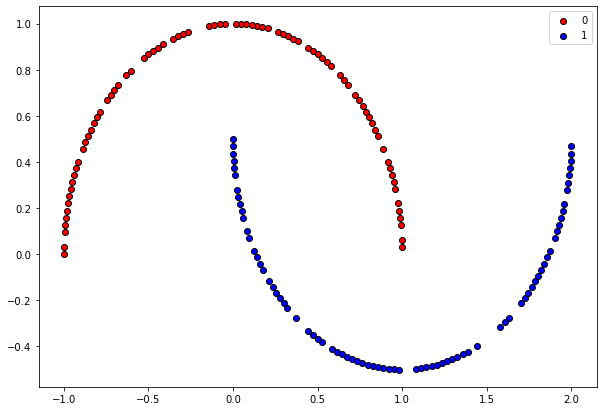

In [4]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X_m, y_m = make_moons(n_samples=200)
X_train, X_test, y_train, y_test = train_test_split(X_m, y_m, test_size=0.2)

labels = [0, 1]
colors = ('red', 'blue')

plt.figure(figsize=(10, 7))
for i, color in zip(labels, colors):
    plt.scatter(X_train[y_train == i, 0], X_train[y_train == i, 1], 
                c=color, label=i, edgecolor='black')
    
plt.legend()
plt.show()

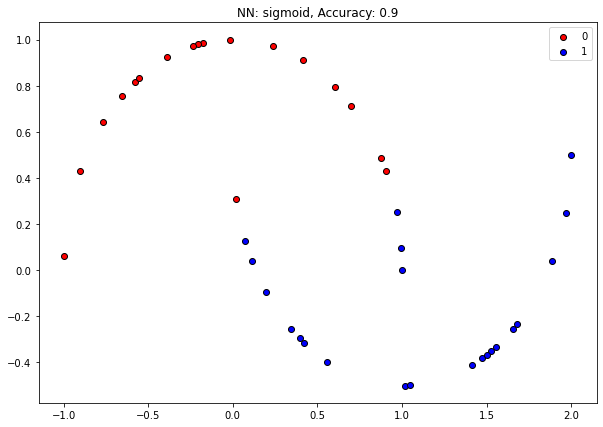

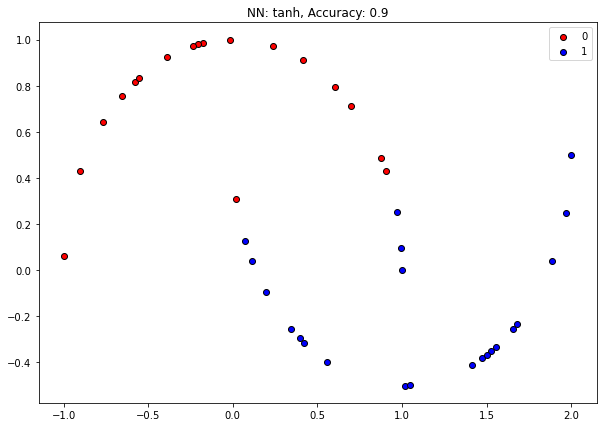

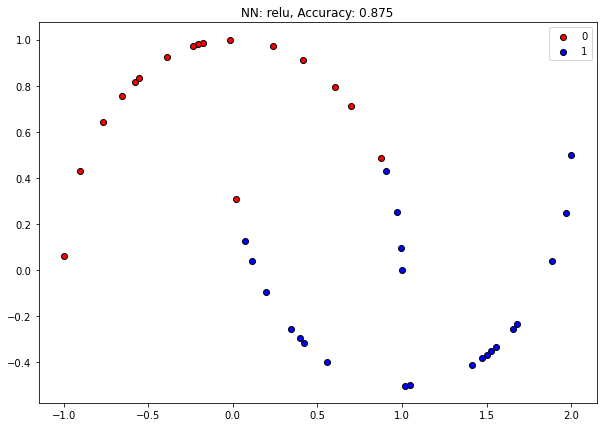

In [5]:
from sklearn.metrics import accuracy_score

functions = ['sigmoid', 'tanh', 'relu']
cost_functions = ['Logistic', 'MSE', 'MSE']
neurons = []
accuracies = []
batch_size = 40

for func, c_f in zip(functions, cost_functions):
    nn = NNOneHiddenLayer(hidden_units=15, activation=func, cost_function=c_f,
                          n_iter=250, eta=0.01, learning_schedule=learning_schedule, 
                          random_state=42)

    y_train_enc = encode(y_train)

    nn.fit(X_train.T, y_train_enc.T, batch_size=batch_size)
    neurons.append(nn)
    y_pred = nn.predict(X_test.T)
    accuracy = accuracy_score(y_pred, y_test)
    accuracies.append(accuracy)
    
    labels = [0, 1]
    colors = ('red', 'blue')

    plt.figure(figsize=(10, 7))
    plt.title(f"NN: {nn.activation}, Accuracy: {accuracy}")
    for i, color in zip(labels, colors):
        plt.scatter(X_test[y_pred == i, 0], X_test[y_pred == i, 1], 
                    c=color, label=i, edgecolor='black')

    plt.legend()
    plt.show()
    
    

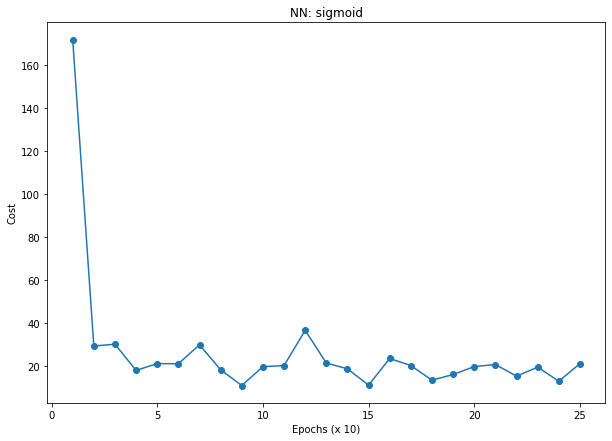

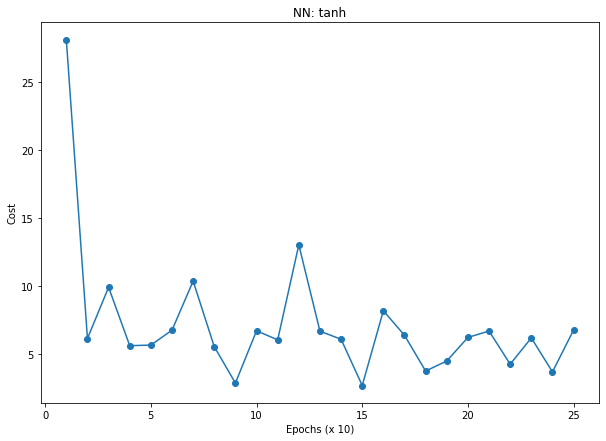

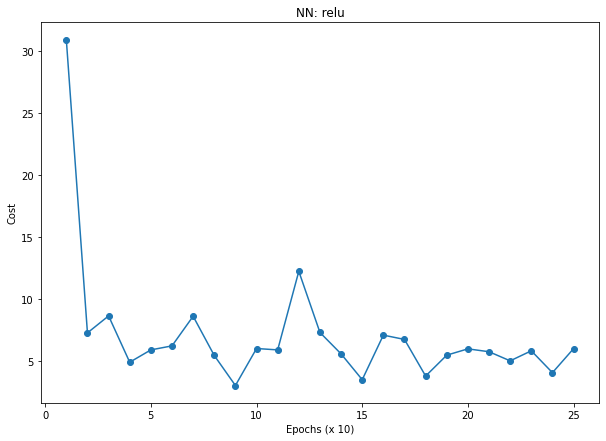

In [6]:
for nn in neurons:
    cost = nn.costs_
    
    plt.figure(figsize=(10, 7))
    plt.title(f'NN: {nn.activation}')
    plt.plot(range(1, len(cost) + 1), cost, 'o-')
    plt.xlabel(f'Epochs (x {int(nn.ratio_cost)})')
    plt.ylabel('Cost')
    plt.show()